# Дали ще се подобри резултата ако намалим боря на чистите/ увеличим боря на токсичните коментари?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict

In [23]:
data = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
tags = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X = data.comment_text
Y = data[tags]
data[0:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
def show_scores(pipeline, x = X, y = Y):
    for tag in tags:
        print('*****',tag,'*****')
        print('Cross val score', cross_val_score(pipeline, x, y[tag], cv=3, n_jobs=2))
        predict = cross_val_predict(pipeline, x, y[tag], cv=3, n_jobs=2)
        print('Accuracy',accuracy_score(y[tag], predict))
        print('Precision', precision_score(y[tag], predict))
        print('Recall', recall_score(y[tag], predict))
        plot_confusion_matrix(y[tag], predict, classes=[0, 1], normalize=True)

In [18]:
def submission(pipeline_arr, name, x = X, y = Y):
    predictions = []
    
    for tag in tags:
        pipeline = Pipeline(pipeline_arr)
        
        model = pipeline.fit(X, Y[tag])
    
        predictions.append(model.predict_proba(test.comment_text)[:,1])
        
    submit_file = pd.DataFrame(np.array(predictions).T, columns=tags, index=test.id)
    submit_file.to_csv('../Submissions/' + name)
    
    print('DONE.')

## 1. Да намалим чистите коментари на половина..

In [11]:
all_toxic = data[data.toxic + data.severe_toxic + data.obscene + data.threat + data.insult + data.identity_hate > 0]
all_clear = data[data.toxic + data.severe_toxic + data.obscene + data.threat + data.insult + data.identity_hate == 0]

In [12]:
first, second = np.split(all_clear, 2, axis=0)
first = first.append(all_toxic)
first

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0


***** toxic *****
Cross val score [ 0.93139932  0.93136285  0.92405884]
Accuracy 0.928940362693
Precision 0.905667144907
Recall 0.660389695305


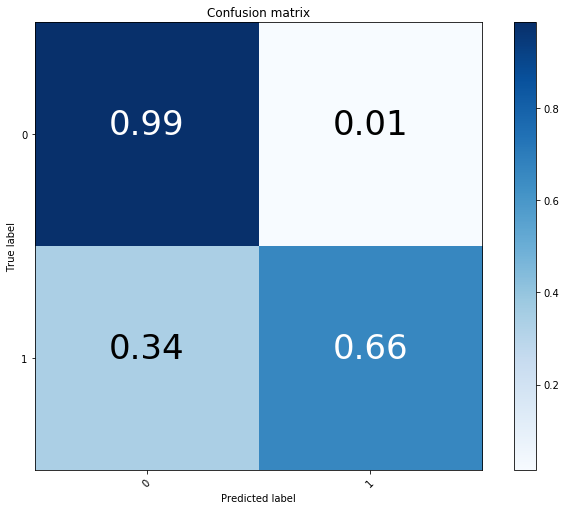

***** severe_toxic *****
Cross val score [ 0.98491468  0.98477816  0.92637723]
Accuracy 0.965357573551
Precision 0.212301587302
Recall 0.335423197492


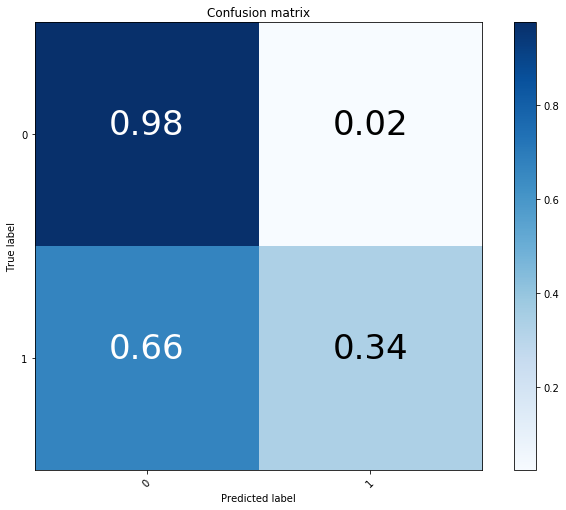

***** obscene *****
Cross val score [ 0.96122867  0.96074951  0.93248916]
Accuracy 0.951489226148
Precision 0.817478379609
Recall 0.637708604569


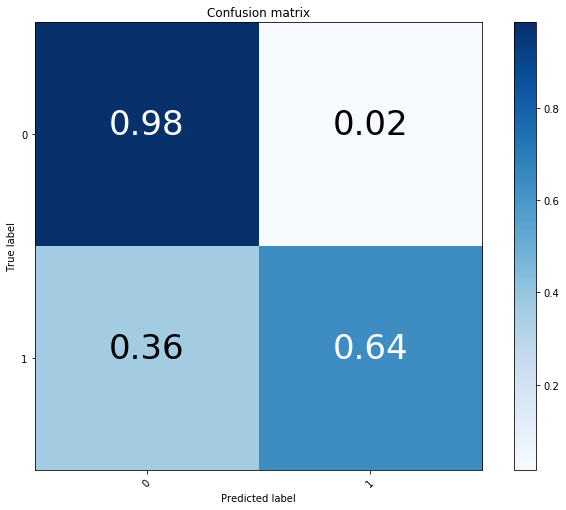

***** threat *****
Cross val score [ 0.99484642  0.9953582   0.97279771]
Accuracy 0.987667523721
Precision 0.110539845758
Recall 0.179916317992


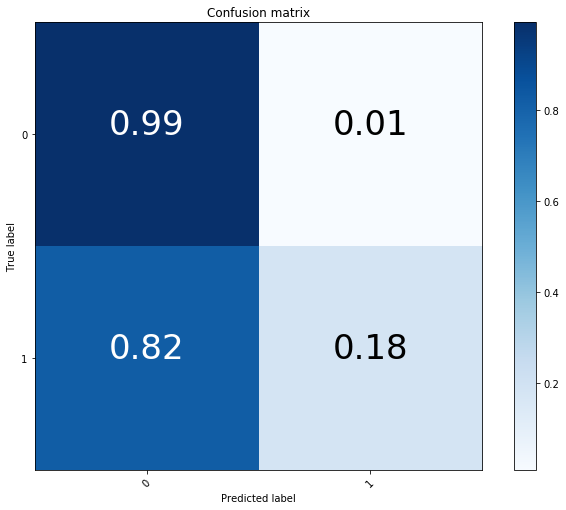

***** insult *****
Cross val score [ 0.95273038  0.95235495  0.90385009]
Accuracy 0.936312544085
Precision 0.679138500236
Recall 0.548432144217


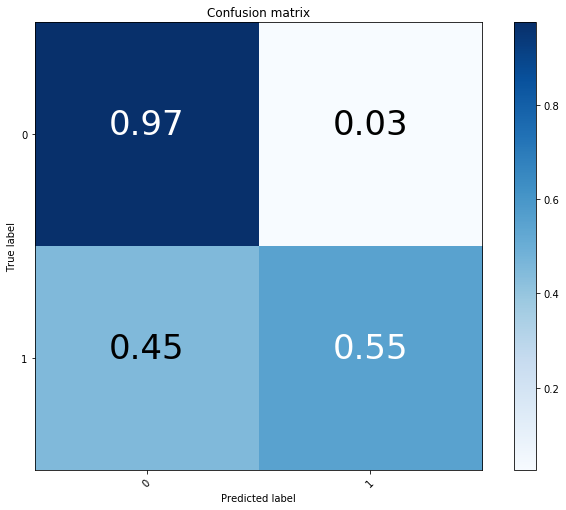

***** identity_hate *****
Cross val score [ 0.98569966  0.98597222  0.91760811]
Accuracy 0.963093585747
Precision 0.127883447997
Recall 0.224911032028


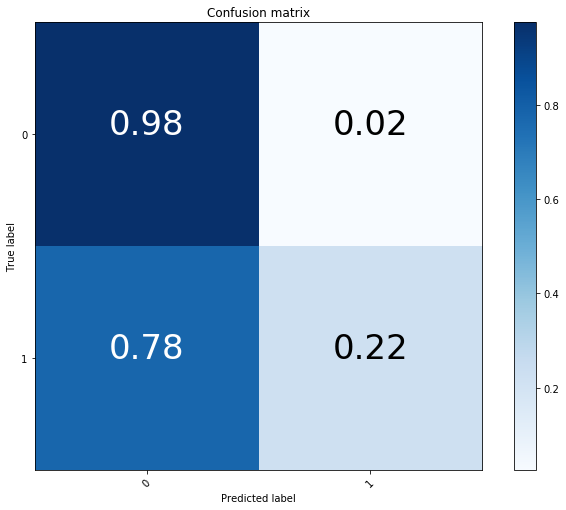

In [21]:
baseline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

show_scores(baseline, first.comment_text, first[tags])

## Precision и Recall на някои класове се подобри, на други се влоши..

### Направо да събмитваме..

In [24]:
submission([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
], 'tfidf-logistic-regression-half-clean1.csv', first.comment_text, first[tags])

DONE.


## Това подобри резултата на 0.9726
### Да пробваме и с другата половина

In [25]:
second = second.append(all_toxic)
second

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79878,d5bf46ef4a7127bd,"""\n\n Whats wrong with this? you have just pro...",0,0,0,0,0,0
79880,d5c14833d99010bd,Why do you refer to me as an owner of the arti...,0,0,0,0,0,0
79881,d5c2c7cba065f266,Response section \n\nAnyone know what's up wit...,0,0,0,0,0,0
79882,d5c32f33758961f4,"""Hello RHaworth: I always read and consider yo...",0,0,0,0,0,0
79883,d5c3bc61ca7557e0,"HASN'T, not has'nt. Please keep that in mind. ...",0,0,0,0,0,0
79884,d5c3cf814bfa519c,"""The article reads: """"In the first (modern-day...",0,0,0,0,0,0
79886,d5c53f8ca19a82af,"That's well and good, but he still doesn't out...",0,0,0,0,0,0
79887,d5c5b1c2f4aff55c,"""\n\n Moved your article into """"userspace"""" \n...",0,0,0,0,0,0
79888,d5c7bfac18038c89,Very good. Thank you.,0,0,0,0,0,0
79890,d5c8b9405ee1defc,Kwami participated and even initiated personal...,0,0,0,0,0,0


In [26]:
submission([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
], 'tfidf-logistic-regression-half-clean2.csv', second.comment_text, second[tags])

DONE.


# Резултат: 0.9725

#### Изпробвах разделяне на четири - не повиши резултата.

## Нека обединим резултатите от двата модела.

In [32]:
first_half = pd.read_csv('../Submissions/tfidf-logistic-regression-half-clean1.csv')
first_half[:10]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998337,0.179390,0.994809,0.046207,0.961407,0.280959
1,0000247867823ef7,0.006600,0.001563,0.004007,0.000433,0.005721,0.003058
2,00013b17ad220c46,0.042410,0.006402,0.020820,0.001987,0.023446,0.006136
3,00017563c3f7919a,0.003176,0.001637,0.003102,0.001038,0.003707,0.000930
4,00017695ad8997eb,0.034391,0.004016,0.011185,0.001724,0.011583,0.003610
5,0001ea8717f6de06,0.007501,0.001821,0.004086,0.002148,0.008221,0.002098
6,00024115d4cbde0f,0.004510,0.000810,0.004054,0.000595,0.004355,0.001308
7,000247e83dcc1211,0.476882,0.005342,0.052117,0.002232,0.093187,0.007835
8,00025358d4737918,0.010323,0.001546,0.008374,0.000942,0.005573,0.002347
9,00026d1092fe71cc,0.005263,0.000885,0.005199,0.000839,0.005288,0.001267


In [33]:
second_half = pd.read_csv('../Submissions/tfidf-logistic-regression-half-clean2.csv')
second_half[:10]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998337,0.179390,0.994809,0.046207,0.961407,0.280959
1,0000247867823ef7,0.006600,0.001563,0.004007,0.000433,0.005721,0.003058
2,00013b17ad220c46,0.042410,0.006402,0.020820,0.001987,0.023446,0.006136
3,00017563c3f7919a,0.003176,0.001637,0.003102,0.001038,0.003707,0.000930
4,00017695ad8997eb,0.034391,0.004016,0.011185,0.001724,0.011583,0.003610
5,0001ea8717f6de06,0.007501,0.001821,0.004086,0.002148,0.008221,0.002098
6,00024115d4cbde0f,0.004510,0.000810,0.004054,0.000595,0.004355,0.001308
7,000247e83dcc1211,0.476882,0.005342,0.052117,0.002232,0.093187,0.007835
8,00025358d4737918,0.010323,0.001546,0.008374,0.000942,0.005573,0.002347
9,00026d1092fe71cc,0.005263,0.000885,0.005199,0.000839,0.005288,0.001267


In [35]:
combined = (first_half.drop('id', axis=1) + second_half.drop('id', axis=1)) / 2
combined.index = first_half['id']
combined[:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.998337,0.179390,0.994809,0.046207,0.961407,0.280959
0000247867823ef7,0.006600,0.001563,0.004007,0.000433,0.005721,0.003058
00013b17ad220c46,0.042410,0.006402,0.020820,0.001987,0.023446,0.006136
00017563c3f7919a,0.003176,0.001637,0.003102,0.001038,0.003707,0.000930
00017695ad8997eb,0.034391,0.004016,0.011185,0.001724,0.011583,0.003610
0001ea8717f6de06,0.007501,0.001821,0.004086,0.002148,0.008221,0.002098
00024115d4cbde0f,0.004510,0.000810,0.004054,0.000595,0.004355,0.001308
000247e83dcc1211,0.476882,0.005342,0.052117,0.002232,0.093187,0.007835
00025358d4737918,0.010323,0.001546,0.008374,0.000942,0.005573,0.002347


In [36]:
combined.to_csv('../Submissions/tfidf-logistic-regression-halves-combined.csv')

## Това подобри резултата - 0.9736

#### Идеи:
- Random Search на двете половинки + комбинация